In [33]:
# import open3d as o3d
import torch
import numpy as np
import open3d as o3d
from pathlib import Path

import cv2
import numpy as np

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Capturing Object from different views

In [ ]:
bunny = o3d.io.read_triangle_mesh("/root/multiview-robust-clip/data/shapes/bunny.obj")
bunny.compute_vertex_normals()

In [ ]:
%%capture
bunny = o3d.io.read_triangle_mesh("/root/multiview-robust-clip/data/shapes/bunny.obj")
bunny.compute_vertex_normals()

angle = 5

rot_matrix = np.array([[np.cos(np.radians(angle)), 0, -np.sin(np.radians(angle))],
                             [0, 1, 0],
                             [np.sin(np.radians(angle)), 0, np.cos(np.radians(angle))]])

current_angle = 0  
for i in range(360 // angle):
    bunny.rotate(rot_matrix)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(bunny)
    vis.update_geometry(bunny)
    vis.capture_screen_image(f'cameraparams_{current_angle:03d}.png', do_render=True)

    current_angle += angle


In [ ]:
o3d.visualization.draw_plotly([bunny])

# Evaluating CLIP features

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device('cuda')

image_path = Path("/root/multiview-robust-clip/data/renderings")

images = [Image.open(x) for x in sorted(image_path.iterdir())]

inputs = processor(text=["a photo of the stanford bunny"], images=images, return_tensors="pt", padding=False).to(device)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [ ]:
image_embeds = outputs['image_embeds'].detach().cpu().numpy()
cosine_similarities = cosine_similarity(image_embeds, image_embeds)
euclidean_distances = euclidean_distances(image_embeds, image_embeds)
# CALCULATE SIMILARITIES
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cosine_similarities, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Cosine Similarity')

plt.subplot(1, 2, 2)
plt.imshow(euclidean_distances, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Euclidean Distance')

plt.show()

In [ ]:
# MAKE VIDEO OF THE 360 DEGREE ROTATION

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (1920, 1080))


# Load images and write to video
for image in images:
    image_np = np.array(image)
    out.write(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

# Release the VideoWriter object
out.release()


# Analyze Objaverse data

In [4]:
renderings = Path("/root/multiview-robust-clip/data/objaverse/renderings")

In [12]:
from torchmetrics.functional.pairwise import pairwise_cosine_similarity

cossim_list = list()
for shape in renderings.iterdir():
    embeddings = list()
    for pt in sorted(shape.glob("*.pt")):
        embeddings.append(torch.load(pt))
    embeddings = torch.stack(embeddings)
    simm = pairwise_cosine_similarity(embeddings)
    cossim_list.append(simm)

In [16]:
all_sim = torch.stack(cossim_list)
mean_sim = all_sim.mean(dim=0)
std_sim = all_sim.std(dim=0)

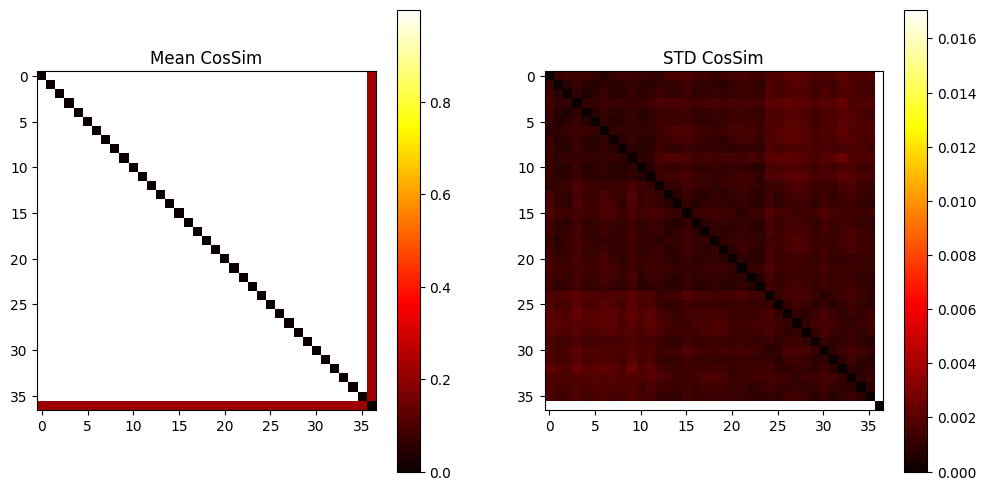

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mean_sim, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Mean CosSim')

plt.subplot(1, 2, 2)
plt.imshow(std_sim, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('STD CosSim')

plt.show()

In [20]:
mean_sim

tensor([[0.0000, 0.9995, 0.9995,  ..., 0.9992, 0.9993, 0.2225],
        [0.9995, 0.0000, 0.9997,  ..., 0.9993, 0.9993, 0.2225],
        [0.9995, 0.9997, 0.0000,  ..., 0.9993, 0.9993, 0.2225],
        ...,
        [0.9992, 0.9993, 0.9993,  ..., 0.0000, 0.9997, 0.2225],
        [0.9993, 0.9993, 0.9993,  ..., 0.9997, 0.0000, 0.2225],
        [0.2225, 0.2225, 0.2225,  ..., 0.2225, 0.2225, 0.0000]])

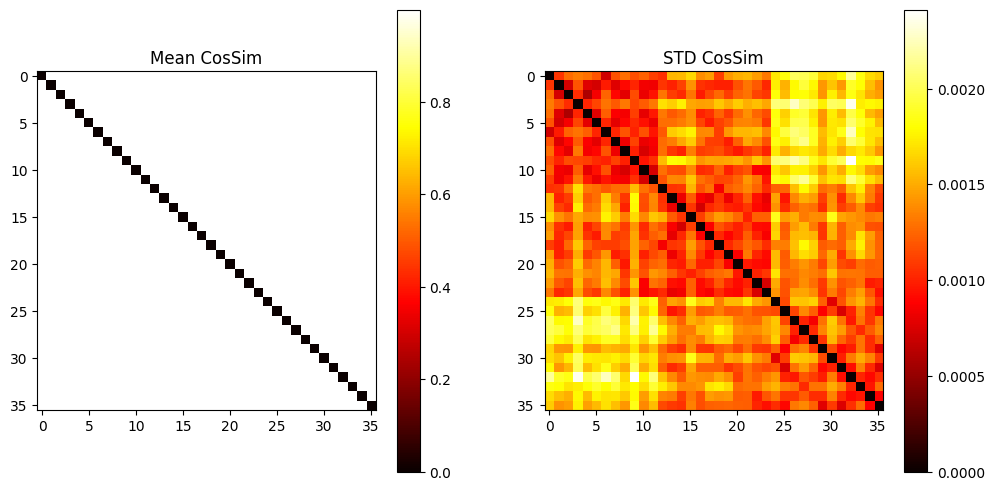

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mean_sim[:36, :36], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Mean CosSim')

plt.subplot(1, 2, 2)
plt.imshow(std_sim[:36, :36], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('STD CosSim')

plt.show()

In [31]:

device = torch.device('cuda')
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

sample_image = renderings / "323851f10fd7483aa803594767ba693a"

images = [Image.open(x) for x in sorted(sample_image.glob("*.png"))]

inputs = processor(text=["test test 123"], images=images, return_tensors="pt", padding=False).to(device)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [38]:
pairwise_cosine_similarity(torch.Tensor(image_embeds))

tensor([[0.0000, 0.8798, 0.8690,  ..., 0.8423, 0.7625, 0.8188],
        [0.8798, 0.0000, 0.8684,  ..., 0.8483, 0.8377, 0.8687],
        [0.8690, 0.8684, 0.0000,  ..., 0.8367, 0.7685, 0.8312],
        ...,
        [0.8423, 0.8483, 0.8367,  ..., 0.0000, 0.8909, 0.9391],
        [0.7625, 0.8377, 0.7685,  ..., 0.8909, 0.0000, 0.9396],
        [0.8188, 0.8687, 0.8312,  ..., 0.9391, 0.9396, 0.0000]])

In [39]:
image_embeds = outputs['image_embeds'].detach().cpu().numpy()
cosine_similarities = pairwise_cosine_similarity(image_embeds)
euc_dist = euclidean_distances(image_embeds, image_embeds)
# CALCULATE SIMILARITIES
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cosine_similarities, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Cosine Similarity')

plt.subplot(1, 2, 2)
plt.imshow(euc_dist, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Euclidean Distance')

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

In [61]:
emb_list = list()
for pt in sorted(renderings.glob("323851f10fd7483aa803594767ba693a/*.pt")):
    emb_list.append(torch.load(pt))
emb_list = torch.stack(emb_list[:36])
simm = pairwise_cosine_similarity(emb_list)

In [64]:
png = "/root/multiview-robust-clip/data/objaverse/renderings/323851f10fd7483aa803594767ba693a/000.png"
clip_emb_path = "/root/multiview-robust-clip/data/objaverse/renderings/323851f10fd7483aa803594767ba693a/clip_embed_000.pt"

In [65]:
clip_emb = torch.load(clip_emb_path)

In [68]:
from src.models.vlm import VLM

In [97]:
mdoel = VLM(torch.device('cpu'), 'clip')

In [82]:
img_image = Image.open(png)

In [101]:
plt_out = mdoel.forward_image(img_plt_torch)

In [102]:
plt_out

tensor([[-1.9858e-01, -2.5193e-01, -5.2368e-01, -5.6809e-02,  1.3262e-01,
         -4.6224e-02, -3.8393e-01,  1.2825e+00,  2.7046e-01,  2.6302e-01,
          4.5451e-01, -1.2255e-01,  4.3737e-01, -7.4333e-03, -1.2608e-01,
          3.9458e-02,  1.8705e-01,  1.8388e-01,  4.4660e-02,  3.2925e-01,
          3.7090e-01,  1.8652e-01, -1.1193e-01, -9.1242e-02, -5.8357e-02,
         -1.8126e-01, -4.3520e-01, -6.9167e-02,  3.1481e-01, -3.3147e-01,
         -1.7926e-01,  1.8401e-01, -2.2858e-01,  3.6096e-03, -6.7628e-01,
         -2.2009e-01,  8.6833e-02, -2.2754e-01,  4.6987e-02, -1.6768e+00,
         -2.8895e-01,  2.7635e-01, -1.8829e-01,  4.3682e-01, -2.4488e-01,
          2.2230e-01, -2.6579e-01, -1.7012e-01, -6.4954e-02, -2.4184e-01,
         -1.4340e-01, -3.5825e-01,  4.3024e-01,  4.7834e-02,  9.2173e-02,
          1.6628e-01,  1.8217e-01, -8.3338e-02, -1.2539e-01, -1.7913e-03,
         -8.2347e-02, -5.3745e-01,  1.3721e-01,  3.6733e-01,  4.7502e-02,
         -3.6506e-02, -1.4314e-01, -4.

In [103]:
clip_emb

tensor([-1.9858e-01, -2.5193e-01, -5.2369e-01, -5.6806e-02,  1.3262e-01,
        -4.6225e-02, -3.8393e-01,  1.2825e+00,  2.7046e-01,  2.6302e-01,
         4.5452e-01, -1.2255e-01,  4.3738e-01, -7.4372e-03, -1.2609e-01,
         3.9460e-02,  1.8705e-01,  1.8387e-01,  4.4659e-02,  3.2925e-01,
         3.7089e-01,  1.8652e-01, -1.1193e-01, -9.1242e-02, -5.8359e-02,
        -1.8126e-01, -4.3521e-01, -6.9165e-02,  3.1480e-01, -3.3147e-01,
        -1.7926e-01,  1.8402e-01, -2.2859e-01,  3.6105e-03, -6.7627e-01,
        -2.2010e-01,  8.6837e-02, -2.2754e-01,  4.6990e-02, -1.6768e+00,
        -2.8895e-01,  2.7635e-01, -1.8829e-01,  4.3682e-01, -2.4488e-01,
         2.2231e-01, -2.6579e-01, -1.7012e-01, -6.4958e-02, -2.4184e-01,
        -1.4341e-01, -3.5825e-01,  4.3024e-01,  4.7837e-02,  9.2173e-02,
         1.6628e-01,  1.8217e-01, -8.3342e-02, -1.2539e-01, -1.7824e-03,
        -8.2348e-02, -5.3745e-01,  1.3721e-01,  3.6734e-01,  4.7504e-02,
        -3.6508e-02, -1.4314e-01, -4.4481e-01, -9.7

In [94]:
img_plt_torch = torch.Tensor(img_plt[:,:,:3])

In [109]:
png

'/root/multiview-robust-clip/data/objaverse/renderings/323851f10fd7483aa803594767ba693a/000.png'

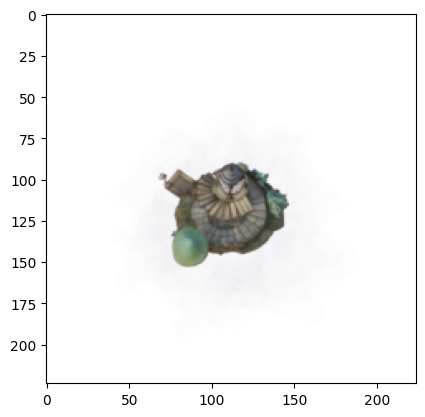

In [110]:
img_plt = Image.open(png)
plt.imshow(img_plt)

In [112]:
type(img_plt)

PIL.PngImagePlugin.PngImageFile

In [120]:
img_im = np.asarray(img_plt)

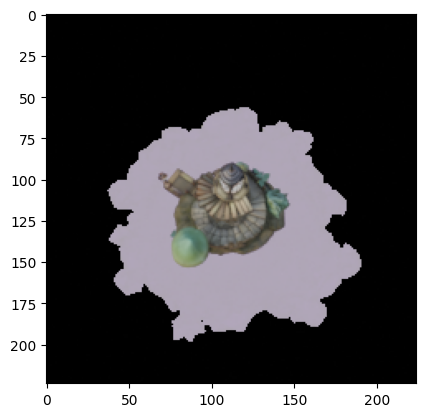

In [123]:
plt.imshow(img_im[:,:,:3])

In [122]:
img_im[100][100]

array([ 78,  73,  69, 255], dtype=uint8)